# MNIST Grid

In [ ]:
## This code is inherited from https://www.kaggle.com/kmader/mnist-based-graphs

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.util import montage
from IPython.display import Image, display, SVG, clear_output, HTML
import networkx as nx
plt.rcParams["figure.figsize"] = (6, 6)
plt.rcParams["figure.dpi"] = 125
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.style.use('ggplot')
sns.set_style("whitegrid", {'axes.grid': False})
plt.rcParams['image.cmap'] = 'gray' # grayscale looks better

def draw_graph_mpl(g, pos=None, ax=None, layout_func=nx.drawing.layout.kamada_kawai_layout):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(25, 25))
    else:
        fig = None
    if pos is None:
        pos = layout_func(g)
    node_color = []
    node_labels = {}
    shift_pos = {}
    for k in g:
        node_color.append(g.nodes[k].get('color', 'green'))
        node_labels[k] = g.nodes[k].get('label', k)
        shift_pos[k] = [pos[k][0], pos[k][1]]
    
    edge_color = []
    edge_width = []
    for e in g.edges():
        edge_color.append(g.edges[e].get('color', 'black'))
        edge_width.append(g.edges[e].get('width', 0.5))
    nx.draw_networkx_edges(g, pos, font_weight='bold', edge_color=edge_color, width=edge_width, ax=ax, alpha=0.5)
    nx.draw_networkx_nodes(g, pos, node_color=node_color, node_shape='p', node_size=300, alpha=0.75)
    nx.draw_networkx_labels(g, shift_pos, labels=node_labels, ax=ax, arrows=True)
    ax.autoscale()
    return fig, ax, pos

In [6]:
import numpy as np
import scipy.sparse as sp
from keras.datasets import mnist as m
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

MNIST_SIZE = 28

Using TensorFlow backend.


In [10]:
def load_data(k=8, noise_level=0.0, random_state=None):
    A = _mnist_grid_graph(k)
    if random_state is not None:
        np.random.seed(random_state)
#     A = _flip_random_edges(A, noise_level).astype(np.float32)

    (X_train, y_train), (X_test, y_test) = m.load_data()
    X_train, X_test = X_train / 255.0, X_test / 255.0
    X_train = X_train.reshape(-1, MNIST_SIZE ** 2)
    X_test = X_test.reshape(-1, MNIST_SIZE ** 2)

    return X_train, y_train, X_test, y_test, A


def _grid_coordinates(side):
    M = side ** 2
    x = np.linspace(0, 1, side, dtype=np.float32)
    y = np.linspace(0, 1, side, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    z = np.empty((M, 2), np.float32)
    z[:, 0] = xx.reshape(M)
    z[:, 1] = yy.reshape(M)
    return z


def _get_adj_from_data(X, k, **kwargs):
    A = kneighbors_graph(X, k, **kwargs).toarray()
    A = sp.csr_matrix(np.maximum(A, A.T))
    return A


def _mnist_grid_graph(k):
    X = _grid_coordinates(MNIST_SIZE)
    A = _get_adj_from_data(
        X, k, mode='connectivity', metric='euclidean', include_self=False
    )
    return A

In [11]:
X_train, y_train, X_test, y_test, adj = load_data(k=4)

11493376/11490434 [==============================] - 2s 0us/step


In [12]:
xx, yy = np.meshgrid(np.arange(28), np.arange(28))
node_id = ['X:{:02d}_Y:{:02d}'.format(x, y) for x, y in zip(xx.ravel(), yy.ravel())]

/home/datht/anaconda3/envs/transfer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/datht/anaconda3/envs/transfer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


5


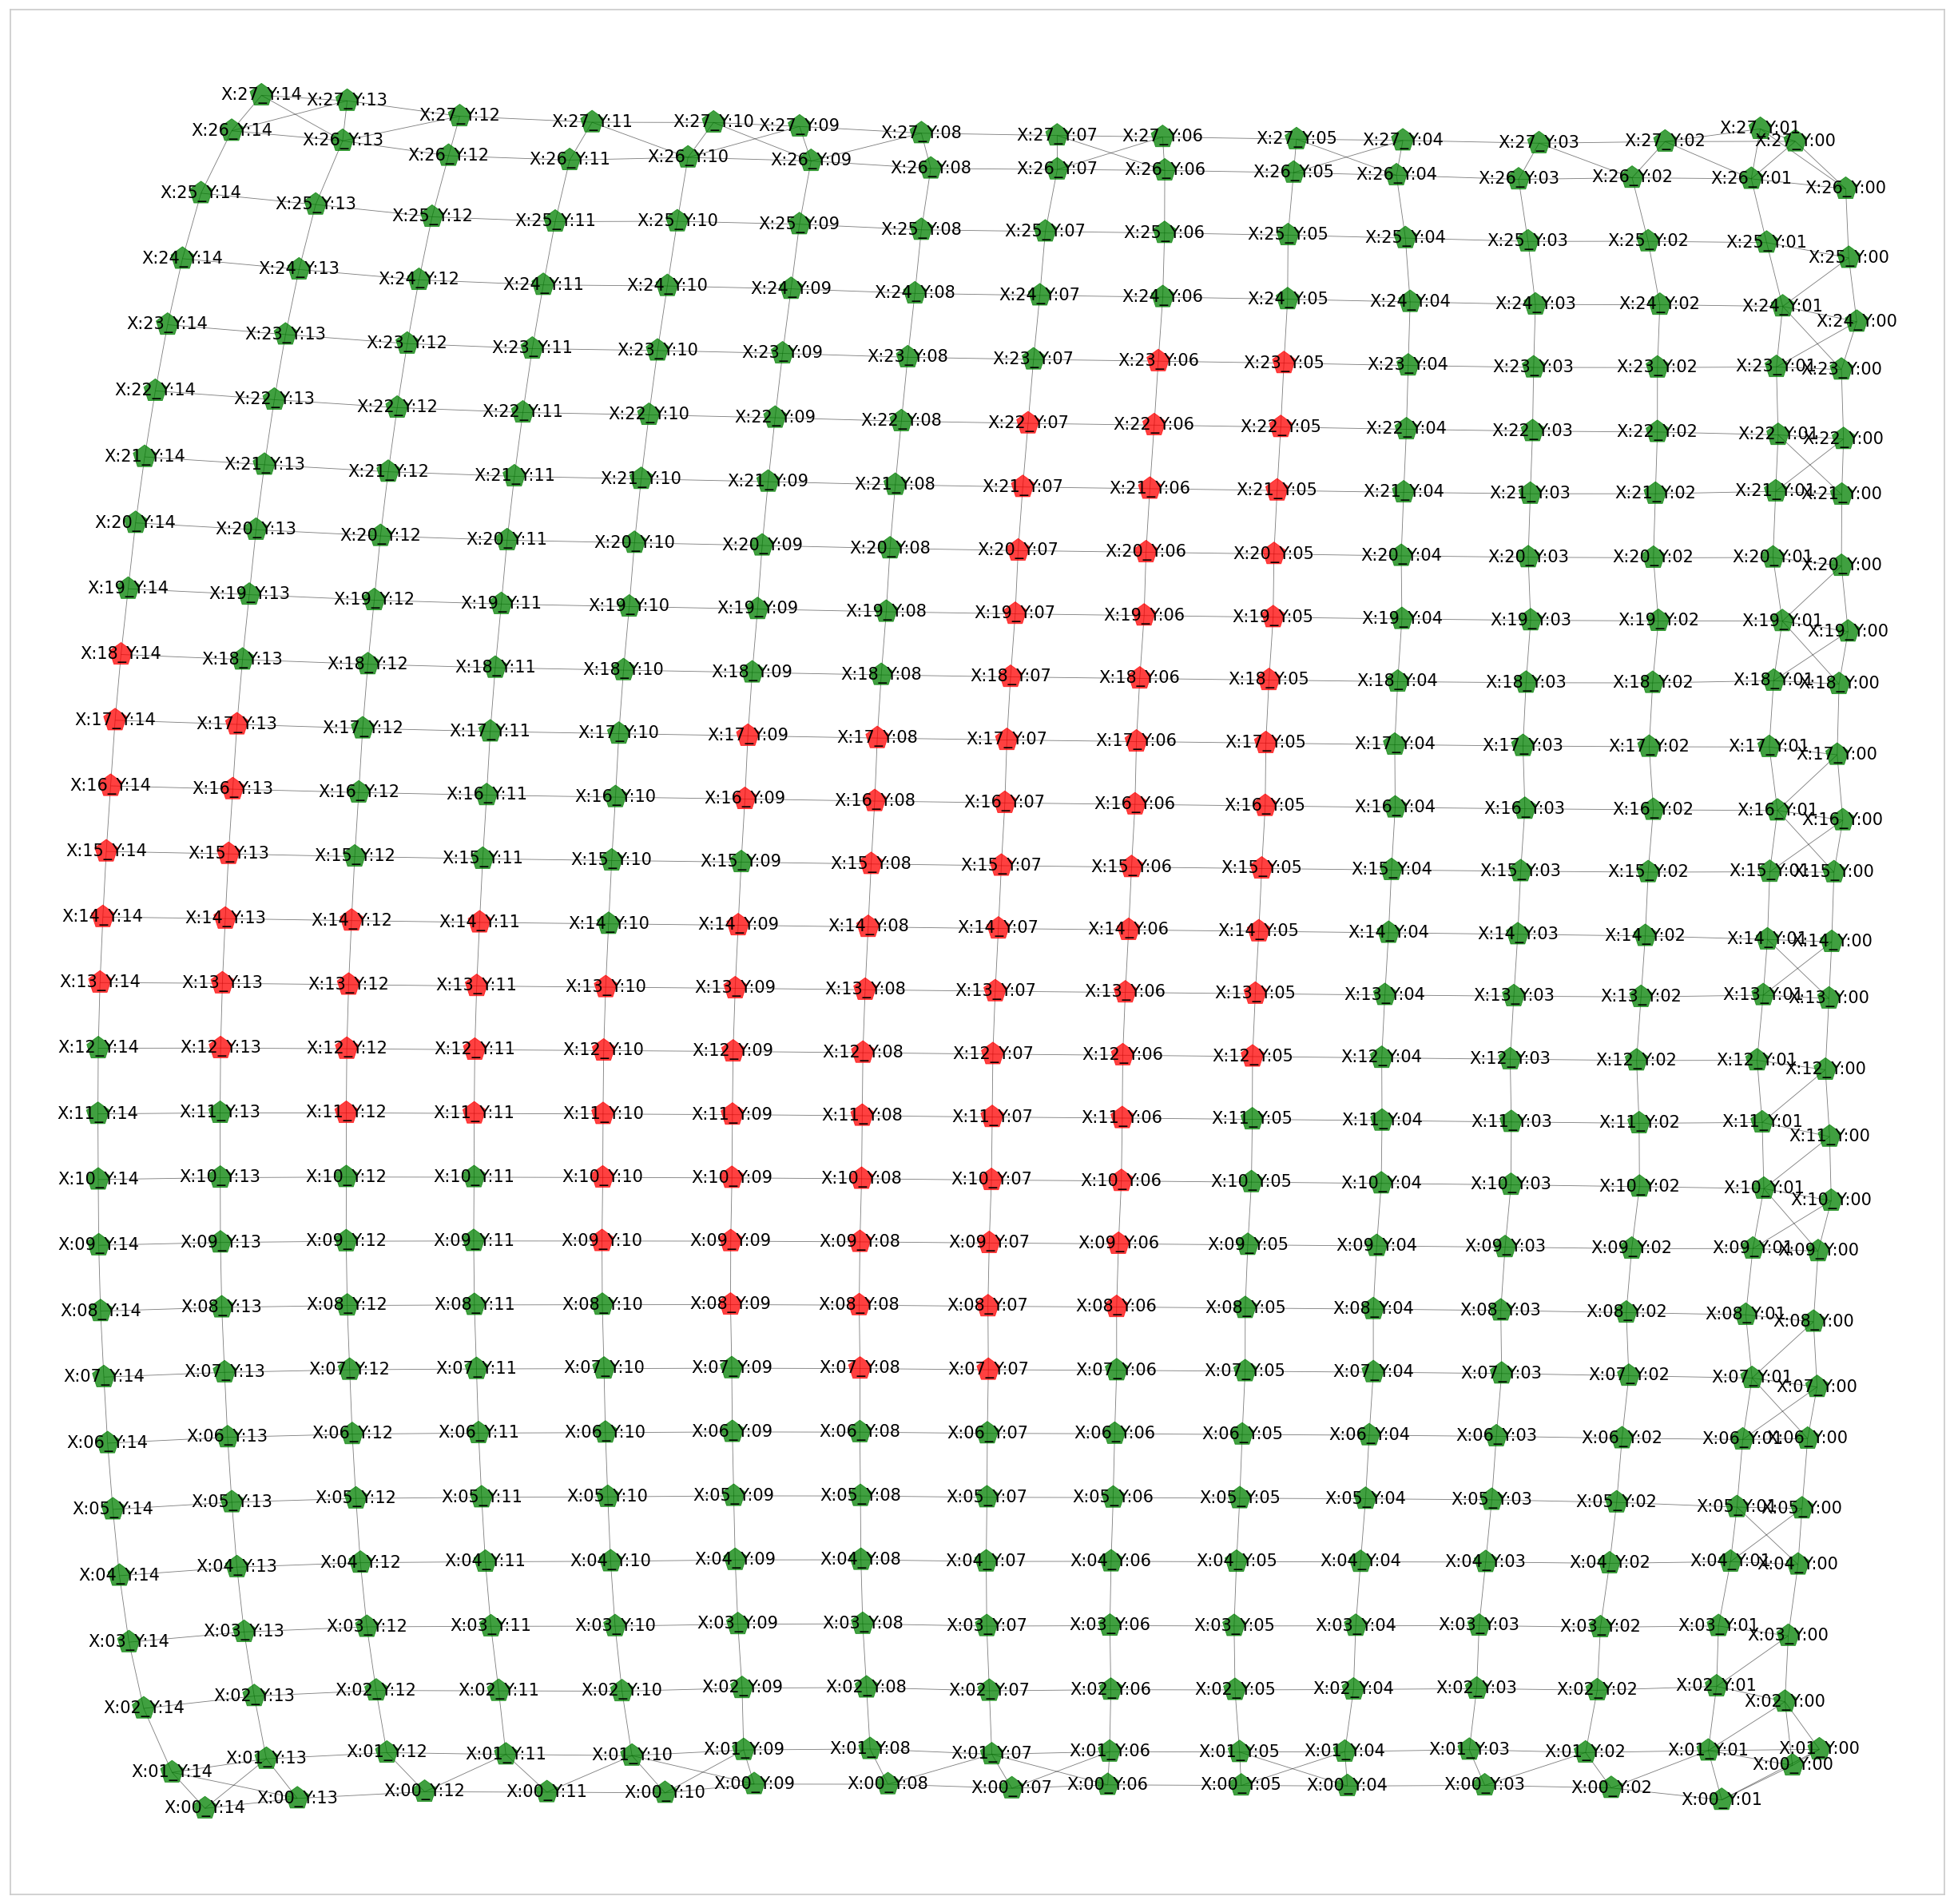

In [23]:
MAX_NODE = 28*15
G = nx.from_scipy_sparse_matrix(adj[:MAX_NODE, :MAX_NODE])
for k, val in zip(G.nodes, X_train[0]):
    G.nodes[k]['label'] = node_id[k]
    G.nodes[k]['color'] = 'red' if val>0 else 'green'
draw_graph_mpl(G);
print(y_train[0])

In [16]:
from torch_geometric.data import DataLoader, Data
import networkx as nx
import torch
from tqdm import tqdm
train_graphs = []
test_graphs = []
for img, label in tqdm(zip(X_train, y_train)):
    G = nx.from_scipy_sparse_matrix(adj)
    edge_index = torch.LongTensor(np.array(G.edges())).t()
    x = torch.FloatTensor(img.reshape(-1, 1))
    y = torch.LongTensor([label])
    train_graphs.append(Data(edge_index=edge_index, x=x, y=y))
for img, label in tqdm(zip(X_test, y_test)):
    G = nx.from_scipy_sparse_matrix(adj)
    edge_index = torch.LongTensor(np.array(G.edges())).t()
    x = torch.FloatTensor(img.reshape(-1, 1))
    y = torch.LongTensor([label])
    test_graphs.append(Data(edge_index=edge_index, x=x, y=y))

60000it [24:42, 40.49it/s]
10000it [04:01, 41.41it/s]


In [24]:
import os
outdir = "data/MNIST_Grid"
if not os.path.isdir(outdir):
    os.makedirs(outdir)
torch.save(train_graphs, outdir+"/training.pt")
torch.save(test_graphs, outdir+"/test.pt")

In [27]:
import torch

def save_graphs(graphs, name='train'):
    As = []
    graph_ids = []
    graph_labels = []
    node_features = []

    i = 1
    graph_id = 1
    for data in graphs:
        edge_index = data.edge_index.numpy()
        x = data.x.numpy()
        y = data.y.numpy()
        edges = edge_index.T + i
        As.append(edges)
        graph_ids += [graph_id for _ in range(x.shape[0])]
        graph_labels.append(y)
        node_features.append(x)
        i += x.shape[0]
        graph_id += 1
    As = np.concatenate(As, axis=0)
    graph_ids = np.array(graph_ids)
    graph_labels = np.concatenate(graph_labels, axis=0)
    node_features= np.concatenate(node_features, axis=0)

    import os
    outdir = f"data/MNIST_Grid_{name}/raw"
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    np.savetxt(f"{outdir}/MNIST_Grid_{name}_A.txt", As, fmt="%d", delimiter=",")
    np.savetxt(f"{outdir}/MNIST_Grid_{name}_graph_indicator.txt", graph_ids, fmt="%d", delimiter=",")
    np.savetxt(f"{outdir}/MNIST_Grid_{name}_graph_labels.txt", graph_labels, fmt="%d", delimiter=",")
    np.savetxt(f"{outdir}/MNIST_Grid_{name}_node_attributes.txt", node_features, fmt="%.5f", delimiter=",")

graphs = torch.load("data/MNIST_Grid/training.pt")
save_graphs(graphs, 'train')
graphs = torch.load("data/MNIST_Grid/test.pt")
save_graphs(graphs, 'test')

# Test generated data

In [28]:
from torch_geometric.datasets import TUDataset
name = 'test'
dataset=TUDataset("data/", f"MNIST_Grid_{name}", use_node_attr=True)

Processing...
Done!


In [29]:
dataset = TUDataset("/home/datht/transfergnn/transfers/data/", "MNIST_Grid_test", cleaned=False, use_node_attr=True)
for i in range(10):
    print(dataset[i].x.sum(), dataset[i].y, (dataset[i].edge_index == dataset[0].edge_index).sum())

tensor(72.3687) tensor([7]) tensor(3242)
tensor(113.1375) tensor([2]) tensor(3242)
tensor(38.7099) tensor([1]) tensor(3242)
tensor(145.1529) tensor([0]) tensor(3242)
tensor(75.4393) tensor([4]) tensor(3242)
tensor(54.3334) tensor([1]) tensor(3242)
tensor(83.0746) tensor([4]) tensor(3242)
tensor(82.5961) tensor([9]) tensor(3242)
tensor(120.5257) tensor([5]) tensor(3242)
tensor(122.9413) tensor([9]) tensor(3242)
